In [1]:
# path = '/home/dpanina/share/rete_tools/examples/'
# path = '/Users/Daria/Dev/Retentioneering/retentioneering-tools-new-arch/'

In [2]:
import sys
# # sys.path.insert(0, '/home/dpanina/retentioneering-tools-new-arch/')
#
sys.path.insert(0, '..')

# Инициация графа

In [3]:
import pandas as pd

from src.eventstream.eventstream import Eventstream
from src.eventstream.schema import RawDataSchema, EventstreamSchema
from src.graph.p_graph import PGraph, EventsNode

raw_data = pd.read_csv( 'simple-onlineshop.csv')

raw_data_schema = RawDataSchema(
                            event_name="event", 
                            event_timestamp="timestamp", 
                            user_id="user_id")

source = Eventstream(
    raw_data=raw_data,
    raw_data_schema=raw_data_schema,
    schema=EventstreamSchema()
)

graph = PGraph(source_stream=source)


In [4]:
raw_data_schema

RawDataSchema(event_name='event', event_timestamp='timestamp', user_id='user_id', event_type=None, custom_cols=[])

In [5]:
raw_data.head(8)

,user_id,event,timestamp
0,219483890,catalog,2019-11-01 17:59:13.273932
1,219483890,product1,2019-11-01 17:59:28.459271
2,219483890,cart,2019-11-01 17:59:29.502214
3,219483890,catalog,2019-11-01 17:59:32.557029
4,964964743,catalog,2019-11-01 21:38:19.283663
5,964964743,cart,2019-11-01 21:38:36.761221
6,964964743,delivery_choice,2019-11-01 21:38:37.564693
7,629881394,main,2019-11-01 22:28:54.791683


In [6]:
source.to_dataframe().head(8)

,event_id,event_type,event_index,event_name,event_timestamp,user_id
0,30da1d31-8f65-4bf1-86c9-aaa1a47e8a71,raw,0,catalog,2019-11-01 17:59:13.273932,219483890
1,6f2c3bf9-69db-4ffb-81ba-1b051271c3c9,raw,1,product1,2019-11-01 17:59:28.459271,219483890
2,349c1446-7269-45ab-9244-684fc1964aca,raw,2,cart,2019-11-01 17:59:29.502214,219483890
3,1ffa7501-52c2-46de-bdd2-41ad74e1c82d,raw,3,catalog,2019-11-01 17:59:32.557029,219483890
4,15adbed9-861d-44b7-9ed9-ee039b82774c,raw,4,catalog,2019-11-01 21:38:19.283663,964964743
5,502b9da4-9fb2-49c0-a26b-b8fce7a4a7d4,raw,5,cart,2019-11-01 21:38:36.761221,964964743
6,b69c702b-2856-45c8-aa60-013eb6743217,raw,6,delivery_choice,2019-11-01 21:38:37.564693,964964743
7,7a389bd2-7b5c-4cf0-b365-70142206e0e4,raw,7,main,2019-11-01 22:28:54.791683,629881394


In [7]:
source_df = source.to_dataframe()

In [8]:
source_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35381 entries, 0 to 35380
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   event_id         35381 non-null  object        
 1   event_type       35381 non-null  object        
 2   event_index      35381 non-null  int64         
 3   event_name       35381 non-null  object        
 4   event_timestamp  35381 non-null  datetime64[ns]
 5   user_id          35381 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 1.9+ MB


## Результат - общие вопросы

1) Конструкция вызовов довольно тяжеловесная, на каждую функцию надо вызвать 2 импорта, задать 2 инстанса и передать параметры словарем. Для аналитиков выглядит не слишком удобно

2)  get_parents() - выдача не оч информативная, есть сейчас возможность посмотреть, какие ноды до текущей?     - [<src.graph.p_graph.EventsNode at 0x7f3892298160>]

3) Можем ли задавать эту схему типов при создании eventstream?

 # Добавление синтетических событий

## StartEnd

### Описание работы функции

Для каждого пользователя добавляются события
```event_type = start, event = start, timestamp = timestamp(first_event)```
```event_type = end, event = end, timestamp = timestamp(end_event)```

In [9]:
from src.data_processors_lib.rete import StartEndEvents, StartEndEventsParams

In [10]:
start_end_events = EventsNode(
    StartEndEvents(params=StartEndEventsParams(**{}))
)

graph.add_node(
    node=start_end_events,
    parents=[graph.root]
)

result = graph.combine(
    node=start_end_events
)
result.to_dataframe().head(8)

,event_id,event_type,event_index,event_name,event_timestamp,user_id
0,b283dcfa-c621-44dc-b63c-f464b78b1f55,start,0,start,2019-11-01 17:59:13.273932,219483890.0
1,30da1d31-8f65-4bf1-86c9-aaa1a47e8a71,raw,1,catalog,2019-11-01 17:59:13.273932,219483890.0
2,6f2c3bf9-69db-4ffb-81ba-1b051271c3c9,raw,2,product1,2019-11-01 17:59:28.459271,219483890.0
3,349c1446-7269-45ab-9244-684fc1964aca,raw,3,cart,2019-11-01 17:59:29.502214,219483890.0
4,1ffa7501-52c2-46de-bdd2-41ad74e1c82d,raw,4,catalog,2019-11-01 17:59:32.557029,219483890.0
5,f7e9abdc-e478-4e13-b242-1c9f7fd55f9e,start,5,start,2019-11-01 21:38:19.283663,964964743.0
6,15adbed9-861d-44b7-9ed9-ee039b82774c,raw,6,catalog,2019-11-01 21:38:19.283663,964964743.0
7,502b9da4-9fb2-49c0-a26b-b8fce7a4a7d4,raw,7,cart,2019-11-01 21:38:36.761221,964964743.0


In [11]:
df = result.to_dataframe()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42883 entries, 0 to 42882
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   event_id         42883 non-null  object        
 1   event_type       42883 non-null  object        
 2   event_index      42883 non-null  int64         
 3   event_name       42883 non-null  object        
 4   event_timestamp  42883 non-null  datetime64[ns]
 5   user_id          42883 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 2.3+ MB


In [12]:
print(len(df[df['user_id'] == 219483890]))
df[df['user_id'] == 219483890]

19


,event_id,event_type,event_index,event_name,event_timestamp,user_id
0,b283dcfa-c621-44dc-b63c-f464b78b1f55,start,0,start,2019-11-01 17:59:13.273932,219483890.0
1,30da1d31-8f65-4bf1-86c9-aaa1a47e8a71,raw,1,catalog,2019-11-01 17:59:13.273932,219483890.0
2,6f2c3bf9-69db-4ffb-81ba-1b051271c3c9,raw,2,product1,2019-11-01 17:59:28.459271,219483890.0
3,349c1446-7269-45ab-9244-684fc1964aca,raw,3,cart,2019-11-01 17:59:29.502214,219483890.0
4,1ffa7501-52c2-46de-bdd2-41ad74e1c82d,raw,4,catalog,2019-11-01 17:59:32.557029,219483890.0
2715,ffded02c-06f9-4ea3-9b70-56a0da773386,raw,2715,main,2019-12-06 16:22:57.484842,219483890.0
2716,637903fe-65bf-44fc-889c-85d762779ed8,raw,2716,catalog,2019-12-06 16:23:01.331109,219483890.0
2717,0d68bc03-1973-4da4-98ed-6b2e8dc6e7cc,raw,2717,catalog,2019-12-06 16:23:48.116617,219483890.0
5721,2c0113a6-b8ca-4642-9f35-db788b230514,raw,5721,main,2020-01-06 22:10:13.635011,219483890.0
5722,50bed9be-5a02-40d0-ae5f-608d24f429ff,raw,5722,catalog,2020-01-06 22:10:15.228575,219483890.0


In [13]:
print(len(source_df[source_df['user_id'] == 219483890]))
source_df[source_df['user_id'] == 219483890].sort_values('event_timestamp')

17


,event_id,event_type,event_index,event_name,event_timestamp,user_id
0,30da1d31-8f65-4bf1-86c9-aaa1a47e8a71,raw,0,catalog,2019-11-01 17:59:13.273932,219483890
1,6f2c3bf9-69db-4ffb-81ba-1b051271c3c9,raw,1,product1,2019-11-01 17:59:28.459271,219483890
2,349c1446-7269-45ab-9244-684fc1964aca,raw,2,cart,2019-11-01 17:59:29.502214,219483890
3,1ffa7501-52c2-46de-bdd2-41ad74e1c82d,raw,3,catalog,2019-11-01 17:59:32.557029,219483890
2245,ffded02c-06f9-4ea3-9b70-56a0da773386,raw,2245,main,2019-12-06 16:22:57.484842,219483890
2246,637903fe-65bf-44fc-889c-85d762779ed8,raw,2246,catalog,2019-12-06 16:23:01.331109,219483890
2247,0d68bc03-1973-4da4-98ed-6b2e8dc6e7cc,raw,2247,catalog,2019-12-06 16:23:48.116617,219483890
4836,2c0113a6-b8ca-4642-9f35-db788b230514,raw,4836,main,2020-01-06 22:10:13.635011,219483890
4837,50bed9be-5a02-40d0-ae5f-608d24f429ff,raw,4837,catalog,2020-01-06 22:10:15.228575,219483890
4838,172510a1-d8ca-4c5b-a4d9-888b94ba01c4,raw,4838,cart,2020-01-06 22:10:42.309028,219483890


In [14]:
check_id = source_df[source_df['user_id'] == 219483890]['event_id'][0]
df[df['event_id'] == check_id]

,event_id,event_type,event_index,event_name,event_timestamp,user_id
1,30da1d31-8f65-4bf1-86c9-aaa1a47e8a71,raw,1,catalog,2019-11-01 17:59:13.273932,219483890.0


In [15]:
source_df[source_df['event_id'] == check_id]

,event_id,event_type,event_index,event_name,event_timestamp,user_id
0,30da1d31-8f65-4bf1-86c9-aaa1a47e8a71,raw,0,catalog,2019-11-01 17:59:13.273932,219483890


In [16]:
source_df['user_id'].nunique(), df['user_id'].nunique()

(3751, 3751)

In [17]:
df[df['event_type'] == 'start']['event_type'].count(), df[df['event_type'] == 'end']['event_type'].count()

(3751, 3751)

In [18]:
df[df['event_type'] == 'raw']['event_type'].count(), source.to_dataframe()['event_type'].count()

(35381, 35381)

In [19]:
source_df['event_type'].value_counts()

raw    35381
Name: event_type, dtype: int64

In [20]:
df['event_type'].value_counts()

raw      35381
start     3751
end       3751
Name: event_type, dtype: int64

In [21]:
len(source_df), len(df)

(35381, 42883)

### Результат

1) [DONE] Исчезло событие, которое до этого было первым с event_id = '556697a2-7439-45c1-bd70-8d970ab7ef61'
Тоже самое произошло с событием End
result.to_dataframe(show_deleted=True) - то все нормально
2) [DONE] Количество raw событий после combine уменьшилось ровно на кол-во пользователей*2
Общая длина eventstream при этом не изменилась
3) [TODO] #params - не должно быть обязательных параметров

## NewResume

### Описание работы функции

Добавляются события new_user/resume_user

Это можно сделать двумя способами:
1) В параметр ```new_users_list = []``` передать список новых пользователей, для них добавятся события:
```event_type = new_user, event = new_user, timestamp = timestamp(first_event)```
При этом для всех остальных, добавятся события:
```event_type = resume, event = resume, timestamp = timestamp(first_event)```
<br>

2) Если параметр ```new_users_list = 'all'```
То всем пользователям добавятся события:
```event_type = new_user, event = new_user, timestamp = timestamp(first_event)```


In [22]:
from src.data_processors_lib.rete import NewResumeEvents, NewResumeParams

new_user_list = [219483890]
# new_user_list = 'all'
new_resume_events = EventsNode(
    NewResumeEvents(params=NewResumeParams(new_users_list=new_user_list)))


graph.add_node(
    node=new_resume_events,
    parents=[graph.root]
)

result = graph.combine(
    node=new_resume_events
)
result.to_dataframe().head(8)

,event_id,event_type,event_index,event_name,event_timestamp,user_id
0,ddaae3a1-54dd-42bb-8af0-b664aac23692,new_user,0,new_user,2019-11-01 17:59:13.273932,219483890.0
1,30da1d31-8f65-4bf1-86c9-aaa1a47e8a71,raw,1,catalog,2019-11-01 17:59:13.273932,219483890.0
2,6f2c3bf9-69db-4ffb-81ba-1b051271c3c9,raw,2,product1,2019-11-01 17:59:28.459271,219483890.0
3,349c1446-7269-45ab-9244-684fc1964aca,raw,3,cart,2019-11-01 17:59:29.502214,219483890.0
4,1ffa7501-52c2-46de-bdd2-41ad74e1c82d,raw,4,catalog,2019-11-01 17:59:32.557029,219483890.0
5,797a7b41-6432-4de4-a22c-f7b5e71178e3,resume,5,resume,2019-11-01 21:38:19.283663,964964743.0
6,15adbed9-861d-44b7-9ed9-ee039b82774c,raw,6,catalog,2019-11-01 21:38:19.283663,964964743.0
7,502b9da4-9fb2-49c0-a26b-b8fce7a4a7d4,raw,7,cart,2019-11-01 21:38:36.761221,964964743.0


In [23]:
df1 = result.to_dataframe()

In [24]:
source_df['event_type'].value_counts()

raw    35381
Name: event_type, dtype: int64

In [25]:
df1['event_type'].value_counts()

raw         35381
resume       3750
new_user        1
Name: event_type, dtype: int64

In [26]:
len(df1), len(source_df)

(39132, 35381)

In [27]:
len(df1) - len(source_df)

3751

In [28]:
graph.get_parents(new_resume_events)

In [29]:
print(len(source_df[source_df['user_id'] == 219483890]))
source_df[source_df['user_id'] == 219483890].sort_values('event_timestamp')

17


,event_id,event_type,event_index,event_name,event_timestamp,user_id
0,30da1d31-8f65-4bf1-86c9-aaa1a47e8a71,raw,0,catalog,2019-11-01 17:59:13.273932,219483890
1,6f2c3bf9-69db-4ffb-81ba-1b051271c3c9,raw,1,product1,2019-11-01 17:59:28.459271,219483890
2,349c1446-7269-45ab-9244-684fc1964aca,raw,2,cart,2019-11-01 17:59:29.502214,219483890
3,1ffa7501-52c2-46de-bdd2-41ad74e1c82d,raw,3,catalog,2019-11-01 17:59:32.557029,219483890
2245,ffded02c-06f9-4ea3-9b70-56a0da773386,raw,2245,main,2019-12-06 16:22:57.484842,219483890
2246,637903fe-65bf-44fc-889c-85d762779ed8,raw,2246,catalog,2019-12-06 16:23:01.331109,219483890
2247,0d68bc03-1973-4da4-98ed-6b2e8dc6e7cc,raw,2247,catalog,2019-12-06 16:23:48.116617,219483890
4836,2c0113a6-b8ca-4642-9f35-db788b230514,raw,4836,main,2020-01-06 22:10:13.635011,219483890
4837,50bed9be-5a02-40d0-ae5f-608d24f429ff,raw,4837,catalog,2020-01-06 22:10:15.228575,219483890
4838,172510a1-d8ca-4c5b-a4d9-888b94ba01c4,raw,4838,cart,2020-01-06 22:10:42.309028,219483890


In [30]:
print(len(df1[df1['user_id'] == 219483890]))
df1[df1['user_id'] == 219483890].sort_values('event_timestamp')

18


,event_id,event_type,event_index,event_name,event_timestamp,user_id
0,ddaae3a1-54dd-42bb-8af0-b664aac23692,new_user,0,new_user,2019-11-01 17:59:13.273932,219483890.0
1,30da1d31-8f65-4bf1-86c9-aaa1a47e8a71,raw,1,catalog,2019-11-01 17:59:13.273932,219483890.0
2,6f2c3bf9-69db-4ffb-81ba-1b051271c3c9,raw,2,product1,2019-11-01 17:59:28.459271,219483890.0
3,349c1446-7269-45ab-9244-684fc1964aca,raw,3,cart,2019-11-01 17:59:29.502214,219483890.0
4,1ffa7501-52c2-46de-bdd2-41ad74e1c82d,raw,4,catalog,2019-11-01 17:59:32.557029,219483890.0
2553,ffded02c-06f9-4ea3-9b70-56a0da773386,raw,2553,main,2019-12-06 16:22:57.484842,219483890.0
2554,637903fe-65bf-44fc-889c-85d762779ed8,raw,2554,catalog,2019-12-06 16:23:01.331109,219483890.0
2555,0d68bc03-1973-4da4-98ed-6b2e8dc6e7cc,raw,2555,catalog,2019-12-06 16:23:48.116617,219483890.0
5388,2c0113a6-b8ca-4642-9f35-db788b230514,raw,5388,main,2020-01-06 22:10:13.635011,219483890.0
5389,50bed9be-5a02-40d0-ae5f-608d24f429ff,raw,5389,catalog,2020-01-06 22:10:15.228575,219483890.0


In [31]:
check_id = source_df[source_df['user_id'] == 219483890]['event_id'][0]
df1[df1['event_id'] == check_id]

,event_id,event_type,event_index,event_name,event_timestamp,user_id
1,30da1d31-8f65-4bf1-86c9-aaa1a47e8a71,raw,1,catalog,2019-11-01 17:59:13.273932,219483890.0


In [32]:
print(len(source_df[source_df['user_id'] == 964964743]))
source_df[source_df['user_id'] == 964964743].sort_values('event_timestamp')

13


,event_id,event_type,event_index,event_name,event_timestamp,user_id
4,15adbed9-861d-44b7-9ed9-ee039b82774c,raw,4,catalog,2019-11-01 21:38:19.283663,964964743
5,502b9da4-9fb2-49c0-a26b-b8fce7a4a7d4,raw,5,cart,2019-11-01 21:38:36.761221,964964743
6,b69c702b-2856-45c8-aa60-013eb6743217,raw,6,delivery_choice,2019-11-01 21:38:37.564693,964964743
2439,2fe1838a-4876-418b-bd15-9ed67896529f,raw,2439,main,2019-12-09 01:42:22.801831,964964743
2440,df188c43-ff63-4113-95f4-6ba2d9bfc03c,raw,2440,catalog,2019-12-09 01:42:23.617764,964964743
2441,45fb4377-11f4-4eb3-b71b-8c42e3eac81b,raw,2441,product2,2019-12-09 01:42:56.877340,964964743
2442,33554711-cd56-4af8-b242-53b521232a63,raw,2442,catalog,2019-12-09 01:43:05.436223,964964743
2443,60fe9b0e-03ac-487b-8b4a-e7566ca93187,raw,2443,catalog,2019-12-09 01:43:36.923178,964964743
2444,b4609a5f-7662-4048-98fa-b03191a30d64,raw,2444,product2,2019-12-09 01:43:41.174195,964964743
2445,e50da712-8b2a-464a-b5e7-9ef59834c43b,raw,2445,cart,2019-12-09 01:43:57.325569,964964743


In [33]:
print(len(df1[df1['user_id'] == 964964743]))
df1[df1['user_id'] == 964964743].sort_values('event_timestamp')

14


,event_id,event_type,event_index,event_name,event_timestamp,user_id
5,797a7b41-6432-4de4-a22c-f7b5e71178e3,resume,5,resume,2019-11-01 21:38:19.283663,964964743.0
6,15adbed9-861d-44b7-9ed9-ee039b82774c,raw,6,catalog,2019-11-01 21:38:19.283663,964964743.0
7,502b9da4-9fb2-49c0-a26b-b8fce7a4a7d4,raw,7,cart,2019-11-01 21:38:36.761221,964964743.0
8,b69c702b-2856-45c8-aa60-013eb6743217,raw,8,delivery_choice,2019-11-01 21:38:37.564693,964964743.0
2768,2fe1838a-4876-418b-bd15-9ed67896529f,raw,2768,main,2019-12-09 01:42:22.801831,964964743.0
2769,df188c43-ff63-4113-95f4-6ba2d9bfc03c,raw,2769,catalog,2019-12-09 01:42:23.617764,964964743.0
2770,45fb4377-11f4-4eb3-b71b-8c42e3eac81b,raw,2770,product2,2019-12-09 01:42:56.877340,964964743.0
2771,33554711-cd56-4af8-b242-53b521232a63,raw,2771,catalog,2019-12-09 01:43:05.436223,964964743.0
2772,60fe9b0e-03ac-487b-8b4a-e7566ca93187,raw,2772,catalog,2019-12-09 01:43:36.923178,964964743.0
2773,b4609a5f-7662-4048-98fa-b03191a30d64,raw,2773,product2,2019-12-09 01:43:41.174195,964964743.0


### зададим ноды последовательно

In [34]:
new_user_list = [219483890]

new_resume_events1 = EventsNode(
    NewResumeEvents(params=NewResumeParams(new_users_list=new_user_list)))


graph.add_node(
    node=new_resume_events1,
    parents=[start_end_events]
)

result_seq = graph.combine(
    node=new_resume_events1
)
result_seq.to_dataframe().head(8)

,event_id,event_type,event_index,event_name,event_timestamp,user_id
0,6df4f244-c84c-405f-80a2-be677284d884,start,0,start,2019-11-01 17:59:13.273932,219483890.0
1,4048d289-e71a-4415-9cf7-13fbee40da48,new_user,1,new_user,2019-11-01 17:59:13.273932,219483890.0
2,30da1d31-8f65-4bf1-86c9-aaa1a47e8a71,raw,2,catalog,2019-11-01 17:59:13.273932,219483890.0
3,6f2c3bf9-69db-4ffb-81ba-1b051271c3c9,raw,3,product1,2019-11-01 17:59:28.459271,219483890.0
4,349c1446-7269-45ab-9244-684fc1964aca,raw,4,cart,2019-11-01 17:59:29.502214,219483890.0
5,1ffa7501-52c2-46de-bdd2-41ad74e1c82d,raw,5,catalog,2019-11-01 17:59:32.557029,219483890.0
6,592995d8-b640-4994-878f-0dd163b5c8a6,start,6,start,2019-11-01 21:38:19.283663,964964743.0
7,77fdf991-794a-43d1-8199-da6fc564df9d,resume,7,resume,2019-11-01 21:38:19.283663,964964743.0


In [35]:
len(result_seq.to_dataframe()), len(source_df)

(46634, 35381)

In [36]:
result_seq.to_dataframe()['event_type'].value_counts()

raw         35381
start        3751
end          3751
resume       3750
new_user        1
Name: event_type, dtype: int64

In [37]:
result.to_dataframe()['event_type'].value_counts()

raw         35381
resume       3750
new_user        1
Name: event_type, dtype: int64

In [38]:
source_df['event_type'].value_counts()

raw    35381
Name: event_type, dtype: int64

In [39]:
df2 = result_seq.to_dataframe()

In [40]:
print(len(df2[df2['user_id'] == 219483890]))
df2[df2['user_id'] == 219483890].sort_values('event_timestamp')

20


,event_id,event_type,event_index,event_name,event_timestamp,user_id
0,6df4f244-c84c-405f-80a2-be677284d884,start,0,start,2019-11-01 17:59:13.273932,219483890.0
1,4048d289-e71a-4415-9cf7-13fbee40da48,new_user,1,new_user,2019-11-01 17:59:13.273932,219483890.0
2,30da1d31-8f65-4bf1-86c9-aaa1a47e8a71,raw,2,catalog,2019-11-01 17:59:13.273932,219483890.0
3,6f2c3bf9-69db-4ffb-81ba-1b051271c3c9,raw,3,product1,2019-11-01 17:59:28.459271,219483890.0
4,349c1446-7269-45ab-9244-684fc1964aca,raw,4,cart,2019-11-01 17:59:29.502214,219483890.0
5,1ffa7501-52c2-46de-bdd2-41ad74e1c82d,raw,5,catalog,2019-11-01 17:59:32.557029,219483890.0
3023,ffded02c-06f9-4ea3-9b70-56a0da773386,raw,3023,main,2019-12-06 16:22:57.484842,219483890.0
3024,637903fe-65bf-44fc-889c-85d762779ed8,raw,3024,catalog,2019-12-06 16:23:01.331109,219483890.0
3025,0d68bc03-1973-4da4-98ed-6b2e8dc6e7cc,raw,3025,catalog,2019-12-06 16:23:48.116617,219483890.0
6273,2c0113a6-b8ca-4642-9f35-db788b230514,raw,6273,main,2020-01-06 22:10:13.635011,219483890.0


In [41]:
graph.get_parents(new_resume_events1)

### Результат

1) [DONE] Обсуждали, что можно задать вот так тип new_users_list: List[int] | str
у меня это не сработало
В итоге поправила - new_users_list: Union[str, List[int]]
2) [TODO] Можно ли как-то проставить конкретное значение "all"?
Пока добавила отбивку
3) [DONE] Дубликаты
    - Задвоились все raw события, кроме первого,
    - Первое событие удалилось по аналогии со start_end_events, проверила по id
    -new_user и resume проставился правильно c правильным timestamp
4) [TODO_analytics]
При задании new_resume_events, должна быть возможность задать параметр "all" - чтобы всем проставить new_user - нужен он такой? нужен ли такой для resume?

## LostPause

### Описание работы функции

Добавлять события lost/pause можно двумя способами:

1) В параметр ```lost_users_list = []``` передать список пользователей, которые ушли из продукта, для них добавятся события:
```event_type = lost, event = lost, timestamp = timestamp(last_raw_event)```
При этом для всех остальных, добавятся события:
```event_type = pause, event = pause, timestamp = timestamp(last_raw_event)```

<br>

2) Или можно задать отсечку с помощью параметра ```lost_cutoff = [Tuple[float, str]]```
И тогда всем юзерам, у которых время между последним событием в его траектории и окончанием всего датасета - больше заданной отсечки, мы проставляем:
```event_type = lost, event = lost, timestamp = timestamp(last_raw_event)```
При этом для всех остальных, добавятся события:
```event_type = pause, event = pause, timestamp = timestamp(last_raw_event)```

### list

In [42]:
from src.data_processors_lib.rete import LostPauseEvents, LostPauseParams

lost_users_list_ = [964964743]

lost_pause_events = EventsNode(
    LostPauseEvents(params=LostPauseParams(lost_users_list=lost_users_list_)))

graph.add_node(
    node=lost_pause_events,
    parents=[graph.root]
)


result = graph.combine(
    node=lost_pause_events
)

In [43]:
df3 = result.to_dataframe()
print(source_df.duplicated(['event_name', 'event_timestamp', 'user_id']).sum())
print(df3.duplicated().sum())

0
0


In [44]:
print(len(df3[df3['user_id'] == 964964743]))
df3[df3['user_id'] == 964964743]

14


,event_id,event_type,event_index,event_name,event_timestamp,user_id
4,15adbed9-861d-44b7-9ed9-ee039b82774c,raw,4,catalog,2019-11-01 21:38:19.283663,964964743.0
5,502b9da4-9fb2-49c0-a26b-b8fce7a4a7d4,raw,5,cart,2019-11-01 21:38:36.761221,964964743.0
6,b69c702b-2856-45c8-aa60-013eb6743217,raw,6,delivery_choice,2019-11-01 21:38:37.564693,964964743.0
2618,2fe1838a-4876-418b-bd15-9ed67896529f,raw,2618,main,2019-12-09 01:42:22.801831,964964743.0
2619,df188c43-ff63-4113-95f4-6ba2d9bfc03c,raw,2619,catalog,2019-12-09 01:42:23.617764,964964743.0
2620,45fb4377-11f4-4eb3-b71b-8c42e3eac81b,raw,2620,product2,2019-12-09 01:42:56.877340,964964743.0
2621,33554711-cd56-4af8-b242-53b521232a63,raw,2621,catalog,2019-12-09 01:43:05.436223,964964743.0
2622,60fe9b0e-03ac-487b-8b4a-e7566ca93187,raw,2622,catalog,2019-12-09 01:43:36.923178,964964743.0
2623,b4609a5f-7662-4048-98fa-b03191a30d64,raw,2623,product2,2019-12-09 01:43:41.174195,964964743.0
2624,e50da712-8b2a-464a-b5e7-9ef59834c43b,raw,2624,cart,2019-12-09 01:43:57.325569,964964743.0


In [45]:
print(len(source_df[source_df['user_id'] == 964964743]))
source_df[source_df['user_id'] == 964964743]

13


,event_id,event_type,event_index,event_name,event_timestamp,user_id
4,15adbed9-861d-44b7-9ed9-ee039b82774c,raw,4,catalog,2019-11-01 21:38:19.283663,964964743
5,502b9da4-9fb2-49c0-a26b-b8fce7a4a7d4,raw,5,cart,2019-11-01 21:38:36.761221,964964743
6,b69c702b-2856-45c8-aa60-013eb6743217,raw,6,delivery_choice,2019-11-01 21:38:37.564693,964964743
2439,2fe1838a-4876-418b-bd15-9ed67896529f,raw,2439,main,2019-12-09 01:42:22.801831,964964743
2440,df188c43-ff63-4113-95f4-6ba2d9bfc03c,raw,2440,catalog,2019-12-09 01:42:23.617764,964964743
2441,45fb4377-11f4-4eb3-b71b-8c42e3eac81b,raw,2441,product2,2019-12-09 01:42:56.877340,964964743
2442,33554711-cd56-4af8-b242-53b521232a63,raw,2442,catalog,2019-12-09 01:43:05.436223,964964743
2443,60fe9b0e-03ac-487b-8b4a-e7566ca93187,raw,2443,catalog,2019-12-09 01:43:36.923178,964964743
2444,b4609a5f-7662-4048-98fa-b03191a30d64,raw,2444,product2,2019-12-09 01:43:41.174195,964964743
2445,e50da712-8b2a-464a-b5e7-9ef59834c43b,raw,2445,cart,2019-12-09 01:43:57.325569,964964743


In [46]:
print(len(source_df[source_df['user_id'] == 629881394]))
print(len(df3[df3['user_id'] == 629881394]))
df3[df3['user_id'] == 629881394]

48
49


,event_id,event_type,event_index,event_name,event_timestamp,user_id
7,7a389bd2-7b5c-4cf0-b365-70142206e0e4,raw,7,main,2019-11-01 22:28:54.791683,629881394.0
9,455e891e-10df-4944-914a-7a297ce2ca92,raw,9,catalog,2019-11-01 22:29:01.049513,629881394.0
11,dc5cde8f-1a46-452a-ba0b-2cbd2fbde31d,raw,11,catalog,2019-11-01 22:29:32.322458,629881394.0
13,44be1b16-584b-42a0-b403-6d7b0b723589,raw,13,catalog,2019-11-01 22:30:09.450839,629881394.0
14,a2580166-2c15-4369-ad25-1cb60f254d17,raw,14,catalog,2019-11-01 22:31:05.565762,629881394.0
15,51cbfd8d-5226-4926-8033-6c3e18c3d342,raw,15,main,2019-11-01 22:31:08.333560,629881394.0
16,7360850e-da7e-40f1-8c2a-d08d964559ba,raw,16,catalog,2019-11-01 22:31:09.010626,629881394.0
17,edcf275b-2fca-4a42-81fb-3c7050f7aaa7,raw,17,product1,2019-11-01 22:31:10.416231,629881394.0
18,1d29c4bf-90f3-4497-bd4f-2a75ac532258,raw,18,catalog,2019-11-01 22:31:43.019527,629881394.0
19,586f4b40-268b-4835-a63e-a947e26d3847,raw,19,catalog,2019-11-01 22:32:01.596163,629881394.0


In [47]:
len(source_df), len(df3)

(35381, 39131)

In [48]:
source_df['event_type'].value_counts()

raw    35381
Name: event_type, dtype: int64

In [49]:
df3.value_counts(['event_type'])

event_type
raw           35380
pause          3750
lost              1
dtype: int64

In [50]:
print(len(df3[df3['user_id'] == 219483890]))
df3[df3['user_id'] == 219483890].sort_values('event_timestamp')

17


,event_id,event_type,event_index,event_name,event_timestamp,user_id
1,6f2c3bf9-69db-4ffb-81ba-1b051271c3c9,raw,1,product1,2019-11-01 17:59:28.459271,219483890.0
2,349c1446-7269-45ab-9244-684fc1964aca,raw,2,cart,2019-11-01 17:59:29.502214,219483890.0
3,1ffa7501-52c2-46de-bdd2-41ad74e1c82d,raw,3,catalog,2019-11-01 17:59:32.557029,219483890.0
2407,ffded02c-06f9-4ea3-9b70-56a0da773386,raw,2407,main,2019-12-06 16:22:57.484842,219483890.0
2408,637903fe-65bf-44fc-889c-85d762779ed8,raw,2408,catalog,2019-12-06 16:23:01.331109,219483890.0
2409,0d68bc03-1973-4da4-98ed-6b2e8dc6e7cc,raw,2409,catalog,2019-12-06 16:23:48.116617,219483890.0
5169,2c0113a6-b8ca-4642-9f35-db788b230514,raw,5169,main,2020-01-06 22:10:13.635011,219483890.0
5170,50bed9be-5a02-40d0-ae5f-608d24f429ff,raw,5170,catalog,2020-01-06 22:10:15.228575,219483890.0
5171,172510a1-d8ca-4c5b-a4d9-888b94ba01c4,raw,5171,cart,2020-01-06 22:10:42.309028,219483890.0
5172,9fb29db5-3b10-4add-b15c-2fa513e303dc,raw,5172,catalog,2020-01-06 22:10:52.255859,219483890.0


In [51]:
print(len(source_df[source_df['user_id'] == 219483890]))
source_df[source_df['user_id'] == 219483890]

17


,event_id,event_type,event_index,event_name,event_timestamp,user_id
0,30da1d31-8f65-4bf1-86c9-aaa1a47e8a71,raw,0,catalog,2019-11-01 17:59:13.273932,219483890
1,6f2c3bf9-69db-4ffb-81ba-1b051271c3c9,raw,1,product1,2019-11-01 17:59:28.459271,219483890
2,349c1446-7269-45ab-9244-684fc1964aca,raw,2,cart,2019-11-01 17:59:29.502214,219483890
3,1ffa7501-52c2-46de-bdd2-41ad74e1c82d,raw,3,catalog,2019-11-01 17:59:32.557029,219483890
2245,ffded02c-06f9-4ea3-9b70-56a0da773386,raw,2245,main,2019-12-06 16:22:57.484842,219483890
2246,637903fe-65bf-44fc-889c-85d762779ed8,raw,2246,catalog,2019-12-06 16:23:01.331109,219483890
2247,0d68bc03-1973-4da4-98ed-6b2e8dc6e7cc,raw,2247,catalog,2019-12-06 16:23:48.116617,219483890
4836,2c0113a6-b8ca-4642-9f35-db788b230514,raw,4836,main,2020-01-06 22:10:13.635011,219483890
4837,50bed9be-5a02-40d0-ae5f-608d24f429ff,raw,4837,catalog,2020-01-06 22:10:15.228575,219483890
4838,172510a1-d8ca-4c5b-a4d9-888b94ba01c4,raw,4838,cart,2020-01-06 22:10:42.309028,219483890


### cutoff

In [52]:
from src.data_processors_lib.rete import LostPauseEvents, LostPauseParams

lost_cutoff_ = (3000, 's')

lost_pause_events_cutoff = EventsNode(
    LostPauseEvents(params=LostPauseParams(lost_cutoff=lost_cutoff_)))

graph.add_node(
    node=lost_pause_events_cutoff,
    parents=[graph.root]
)

result_cutoff = graph.combine(
    node=lost_pause_events_cutoff
)

In [53]:
df4 = result_cutoff.to_dataframe()
print(source_df.duplicated(['event_name', 'event_timestamp', 'user_id']).sum())
print(df4.duplicated(['event_name', 'event_timestamp', 'user_id']).sum())

0
3092


In [54]:
print(len(df4[df4['user_id'] == 964964743]))
df4[df4['user_id'] == 964964743]

14


,event_id,event_type,event_index,event_name,event_timestamp,user_id
4,15adbed9-861d-44b7-9ed9-ee039b82774c,raw,4,catalog,2019-11-01 21:38:19.283663,964964743.0
5,502b9da4-9fb2-49c0-a26b-b8fce7a4a7d4,raw,5,cart,2019-11-01 21:38:36.761221,964964743.0
6,b69c702b-2856-45c8-aa60-013eb6743217,raw,6,delivery_choice,2019-11-01 21:38:37.564693,964964743.0
2618,2fe1838a-4876-418b-bd15-9ed67896529f,raw,2618,main,2019-12-09 01:42:22.801831,964964743.0
2619,df188c43-ff63-4113-95f4-6ba2d9bfc03c,raw,2619,catalog,2019-12-09 01:42:23.617764,964964743.0
2620,45fb4377-11f4-4eb3-b71b-8c42e3eac81b,raw,2620,product2,2019-12-09 01:42:56.877340,964964743.0
2621,33554711-cd56-4af8-b242-53b521232a63,raw,2621,catalog,2019-12-09 01:43:05.436223,964964743.0
2622,60fe9b0e-03ac-487b-8b4a-e7566ca93187,raw,2622,catalog,2019-12-09 01:43:36.923178,964964743.0
2623,b4609a5f-7662-4048-98fa-b03191a30d64,raw,2623,product2,2019-12-09 01:43:41.174195,964964743.0
2624,e50da712-8b2a-464a-b5e7-9ef59834c43b,raw,2624,cart,2019-12-09 01:43:57.325569,964964743.0


In [55]:
print(len(source_df[source_df['user_id'] == 964964743]))
source_df[source_df['user_id'] == 964964743]

13


,event_id,event_type,event_index,event_name,event_timestamp,user_id
4,15adbed9-861d-44b7-9ed9-ee039b82774c,raw,4,catalog,2019-11-01 21:38:19.283663,964964743
5,502b9da4-9fb2-49c0-a26b-b8fce7a4a7d4,raw,5,cart,2019-11-01 21:38:36.761221,964964743
6,b69c702b-2856-45c8-aa60-013eb6743217,raw,6,delivery_choice,2019-11-01 21:38:37.564693,964964743
2439,2fe1838a-4876-418b-bd15-9ed67896529f,raw,2439,main,2019-12-09 01:42:22.801831,964964743
2440,df188c43-ff63-4113-95f4-6ba2d9bfc03c,raw,2440,catalog,2019-12-09 01:42:23.617764,964964743
2441,45fb4377-11f4-4eb3-b71b-8c42e3eac81b,raw,2441,product2,2019-12-09 01:42:56.877340,964964743
2442,33554711-cd56-4af8-b242-53b521232a63,raw,2442,catalog,2019-12-09 01:43:05.436223,964964743
2443,60fe9b0e-03ac-487b-8b4a-e7566ca93187,raw,2443,catalog,2019-12-09 01:43:36.923178,964964743
2444,b4609a5f-7662-4048-98fa-b03191a30d64,raw,2444,product2,2019-12-09 01:43:41.174195,964964743
2445,e50da712-8b2a-464a-b5e7-9ef59834c43b,raw,2445,cart,2019-12-09 01:43:57.325569,964964743


In [56]:
print(len(source_df[source_df['user_id'] == 629881394]))
# source_df[source_df['user_id'] == 629881394]
print(len(df4[df4['user_id'] == 629881394]))
df4[df4['user_id'] == 629881394]

48
49


,event_id,event_type,event_index,event_name,event_timestamp,user_id
7,7a389bd2-7b5c-4cf0-b365-70142206e0e4,raw,7,main,2019-11-01 22:28:54.791683,629881394.0
9,455e891e-10df-4944-914a-7a297ce2ca92,raw,9,catalog,2019-11-01 22:29:01.049513,629881394.0
11,dc5cde8f-1a46-452a-ba0b-2cbd2fbde31d,raw,11,catalog,2019-11-01 22:29:32.322458,629881394.0
13,44be1b16-584b-42a0-b403-6d7b0b723589,raw,13,catalog,2019-11-01 22:30:09.450839,629881394.0
14,a2580166-2c15-4369-ad25-1cb60f254d17,raw,14,catalog,2019-11-01 22:31:05.565762,629881394.0
15,51cbfd8d-5226-4926-8033-6c3e18c3d342,raw,15,main,2019-11-01 22:31:08.333560,629881394.0
16,7360850e-da7e-40f1-8c2a-d08d964559ba,raw,16,catalog,2019-11-01 22:31:09.010626,629881394.0
17,edcf275b-2fca-4a42-81fb-3c7050f7aaa7,raw,17,product1,2019-11-01 22:31:10.416231,629881394.0
18,1d29c4bf-90f3-4497-bd4f-2a75ac532258,raw,18,catalog,2019-11-01 22:31:43.019527,629881394.0
19,586f4b40-268b-4835-a63e-a947e26d3847,raw,19,catalog,2019-11-01 22:32:01.596163,629881394.0


In [57]:
source_df['event_timestamp'].max() - df4[df4['user_id'] == 629881394]['event_timestamp'].max()

Timedelta('30 days 09:28:08.080296')

In [58]:
len(source_df), len(df4)

(35381, 39132)

In [59]:
source_df['event_type'].value_counts()

raw    35381
Name: event_type, dtype: int64

In [60]:
df4.value_counts(['event_type'])

event_type
raw           35381
lost           3744
pause             7
dtype: int64

In [61]:
print(len(df4[df4['user_id'] == 219483890]))
df4[df4['user_id'] == 219483890].sort_values('event_timestamp')

18


,event_id,event_type,event_index,event_name,event_timestamp,user_id
0,30da1d31-8f65-4bf1-86c9-aaa1a47e8a71,raw,0,catalog,2019-11-01 17:59:13.273932,219483890.0
1,6f2c3bf9-69db-4ffb-81ba-1b051271c3c9,raw,1,product1,2019-11-01 17:59:28.459271,219483890.0
2,349c1446-7269-45ab-9244-684fc1964aca,raw,2,cart,2019-11-01 17:59:29.502214,219483890.0
3,1ffa7501-52c2-46de-bdd2-41ad74e1c82d,raw,3,catalog,2019-11-01 17:59:32.557029,219483890.0
2407,ffded02c-06f9-4ea3-9b70-56a0da773386,raw,2407,main,2019-12-06 16:22:57.484842,219483890.0
2408,637903fe-65bf-44fc-889c-85d762779ed8,raw,2408,catalog,2019-12-06 16:23:01.331109,219483890.0
2409,0d68bc03-1973-4da4-98ed-6b2e8dc6e7cc,raw,2409,catalog,2019-12-06 16:23:48.116617,219483890.0
5169,2c0113a6-b8ca-4642-9f35-db788b230514,raw,5169,main,2020-01-06 22:10:13.635011,219483890.0
5170,50bed9be-5a02-40d0-ae5f-608d24f429ff,raw,5170,catalog,2020-01-06 22:10:15.228575,219483890.0
5171,172510a1-d8ca-4c5b-a4d9-888b94ba01c4,raw,5171,cart,2020-01-06 22:10:42.309028,219483890.0


In [62]:
print(len(source_df[source_df['user_id'] == 219483890]))
source_df[source_df['user_id'] == 219483890]

17


,event_id,event_type,event_index,event_name,event_timestamp,user_id
0,30da1d31-8f65-4bf1-86c9-aaa1a47e8a71,raw,0,catalog,2019-11-01 17:59:13.273932,219483890
1,6f2c3bf9-69db-4ffb-81ba-1b051271c3c9,raw,1,product1,2019-11-01 17:59:28.459271,219483890
2,349c1446-7269-45ab-9244-684fc1964aca,raw,2,cart,2019-11-01 17:59:29.502214,219483890
3,1ffa7501-52c2-46de-bdd2-41ad74e1c82d,raw,3,catalog,2019-11-01 17:59:32.557029,219483890
2245,ffded02c-06f9-4ea3-9b70-56a0da773386,raw,2245,main,2019-12-06 16:22:57.484842,219483890
2246,637903fe-65bf-44fc-889c-85d762779ed8,raw,2246,catalog,2019-12-06 16:23:01.331109,219483890
2247,0d68bc03-1973-4da4-98ed-6b2e8dc6e7cc,raw,2247,catalog,2019-12-06 16:23:48.116617,219483890
4836,2c0113a6-b8ca-4642-9f35-db788b230514,raw,4836,main,2020-01-06 22:10:13.635011,219483890
4837,50bed9be-5a02-40d0-ae5f-608d24f429ff,raw,4837,catalog,2020-01-06 22:10:15.228575,219483890
4838,172510a1-d8ca-4c5b-a4d9-888b94ba01c4,raw,4838,cart,2020-01-06 22:10:42.309028,219483890


### ПРоверим параметры

In [63]:
from src.data_processors_lib.rete import LostPauseEvents, LostPauseParams
params ={
            'lost_users_list' : [964964743],
                'lost_cutoff' : (3000, 's')}

lost_pause_events = EventsNode(
    LostPauseEvents(params=LostPauseParams(**params)))

graph.add_node(
    node=lost_pause_events,
    parents=[graph.root]
)

result = graph.combine(
    node=lost_pause_events
)
df3 = result.to_dataframe()

ValueError: lost_cutoff and lost_users_list parameters cannot be used at the same time!

In [64]:
from src.data_processors_lib.rete import LostPauseEvents, LostPauseParams
params ={
             # 'lost_users_list' : [964964743],
            #     'lost_cutoff' : (3000, 's')
    }

lost_pause_events = EventsNode(
    LostPauseEvents(params=LostPauseParams(**params)))

graph.add_node(
    node=lost_pause_events,
    parents=[graph.root]
)

result = graph.combine(
    node=lost_pause_events
)
df3 = result.to_dataframe()

ValueError: lost_cutoff or lost_users_list should be specified!

### Результат

1) [DONE] Нельзя задать единицу измерения отсечки, сейчас тип - lost_cutoff: Optional[List[int]]
2) [DONE] - ломается на этапе импорта из-за параметра функции, если
3) [DONE] Combine - часть событий задваивается, но не очень понятно по какой логике
4) [TODO] Локально возникает ошибка TypeError: _default_func_positive() takes 2 positional arguments but 3 were given -  не актуально, так как убрали эту функцию
5) [TODO_analytics] Продумать общую логику работы - сейчас можно проставить lost/pause или по отсечке, или по списку и функции. И то и другое задавать нельзя.
    - По отсечке - Если от последнего события в траектории прошло больше времени отсечки, то добавляется событие lost, если меньше - pause
    - lost_users_list - список юзеров, которым проставляется событие lost, остальным - pause, Сейчас по списку проставляется - pause

## Truncated

### Описание работы функции

Для ```left_truncated_cutoff``` добавляет событие ```event_type=truncated_left, event=truncated_left``` в начало траектории пользователя, если последнее событие пользователя отстоит от конца датасета больше, чем на ```left_truncated_cutoff```.
 <br>
Для ```right_truncated_cutoff``` добавляет события ```event_type=truncated_right, event=truncated_right``` в конец траектории пользователя, если первое событие пользователя отстоит от начала датасета больше, чем на ```right_truncated_cutoff```.
 <br>
Отсечки удобно определять с помощью гистограмм ```preprocessing.plot_time_delta```

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime as dt
import time

def plot_time_delta(df: pd.DataFrame,
                    dataset_event='start', #'dataset_users_diff=('start', 'end')
                    users_event='end',
                    cutoff=None,
                    uom='s',
                    bins='auto',
                    log_scale=(False, False),
                    figsize=(15,10),
                    l_bound = 1,
                    r_bound = None,
                    alpha: float = 0.4
                    ):

    uom_dict = {'s': 1,
                'm': 60,
                'h': 3600,
                 'd': 24*3600}

    user_col = 'user_id'
    time_col = 'event_timestamp'

    df_time = df.groupby(user_col)[[time_col]].agg({min, max})
    df_time.columns = df_time.columns.get_level_values(1)
    df_time = df_time.reset_index()

    if dataset_event == 'start' and  users_event == 'start':
    #'start_start'
        df_time['time_diff'] = (df_time['min'] - df_time['min'].min())

    elif dataset_event == 'end' and  users_event == 'end':
    #'end_end'
        df_time['time_diff'] = (df_time['max'].max() - df_time['max'])

    elif dataset_event == 'start' and  users_event == 'end':
    #'start_endu'
        df_time['time_diff'] = (df_time['max'] - df_time['min'].min())

    elif dataset_event == 'end' and  users_event == 'start':
    #'end_startu'
        df_time['time_diff'] = (df_time['max'].max() - df_time['min'])

    df_time = df_time[df_time['time_diff'] != 0]
    df_time['time_diff'] = df_time['time_diff'].dt.total_seconds()

    if uom!= 's':
        df_time['time_diff'] = df_time['time_diff']/uom_dict[uom]

    df_time = df_time[(df_time['time_diff'] > l_bound)]

    if r_bound != None:
        df_time = df_time[(df_time['time_diff'] < r_bound)]

    plt.figure(figsize=figsize)

    ax = sns.histplot(x=df_time['time_diff'],
             bins=bins, #'auto',
             log_scale=log_scale,
             color='tab:blue',
             alpha = alpha, # прозрачность
             edgecolor='black',
                     )

    if log_scale[0]:
        plt.xlabel(f'time, {uom}, log_scale ')
    else:
        plt.xlabel(f'time, {uom}')

    if log_scale[1]:
        plt.ylabel('Count users, log_scale ')
    else:
        plt.ylabel('Count users')
    if cutoff:
        plt.axvline(x=cutoff, linewidth=1, color = 'r', linestyle='--', label = 'cutoff')
    plt.title(f'Time between {dataset_event} event of full dataset and {users_event} event of each user')
    plt.show()

In [66]:
source_df.head(1)

,event_id,event_type,event_index,event_name,event_timestamp,user_id
0,30da1d31-8f65-4bf1-86c9-aaa1a47e8a71,raw,0,catalog,2019-11-01 17:59:13.273932,219483890


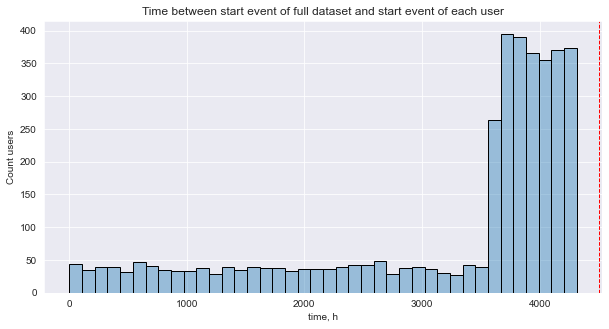

In [67]:
# задавать с какой стороны отсчитывать отсечку - справа или слева

plot_time_delta(source_df,
                    dataset_event='start', #'dataset_users_diff=('start', 'end')
                    users_event='start',
                    cutoff=4500,
                    uom='h',
                    bins=40,
                    log_scale=(False, False),
                    figsize=(10,5),
                    l_bound = 1,
                    r_bound = None
                    )

In [68]:
from src.data_processors_lib.rete import TruncatedEvents, TruncatedParams
params = {
    'left_truncated_cutoff': (1000, 'h'),
    'right_truncated_cutoff': (4000, 'h')
}

truncated_events = EventsNode(
    TruncatedEvents(params=TruncatedParams(**params)))


graph.add_node(
    node=truncated_events,
    parents=[graph.root]
)

result = graph.combine(
    node=truncated_events
)
result.to_dataframe().head(8)

,event_id,event_type,event_index,event_name,event_timestamp,user_id
0,37498fc5-7307-4d84-b91b-4ba045975c8b,truncated_left,0,truncated_left,2019-11-01 17:59:13.273932,219483890.0
1,30da1d31-8f65-4bf1-86c9-aaa1a47e8a71,raw,1,catalog,2019-11-01 17:59:13.273932,219483890.0
2,6f2c3bf9-69db-4ffb-81ba-1b051271c3c9,raw,2,product1,2019-11-01 17:59:28.459271,219483890.0
3,349c1446-7269-45ab-9244-684fc1964aca,raw,3,cart,2019-11-01 17:59:29.502214,219483890.0
4,1ffa7501-52c2-46de-bdd2-41ad74e1c82d,raw,4,catalog,2019-11-01 17:59:32.557029,219483890.0
5,795c7d50-fb8b-4236-8513-e54c7a7f68fb,truncated_left,5,truncated_left,2019-11-01 21:38:19.283663,964964743.0
6,15adbed9-861d-44b7-9ed9-ee039b82774c,raw,6,catalog,2019-11-01 21:38:19.283663,964964743.0
7,502b9da4-9fb2-49c0-a26b-b8fce7a4a7d4,raw,7,cart,2019-11-01 21:38:36.761221,964964743.0


In [69]:
df5 = result.to_dataframe()
print(source_df.duplicated(['event_name', 'event_timestamp', 'user_id']).sum())
df5.duplicated(['event_name', 'event_timestamp', 'user_id']).sum()

0


0

In [70]:
df5['user_id'].nunique()

3751

In [71]:
df5.value_counts('event_type')

event_type
raw                35381
truncated_right     1080
truncated_left       967
dtype: int64

In [72]:
df5[df5['event_type'] == 'truncated_right']['user_id']

25577    973860052.0
25599    102919503.0
25625    146993449.0
25633    169208046.0
25644    147898568.0
            ...     
37383    125426031.0
37391     26773318.0
37396    965024600.0
37403    831491833.0
37419    962761227.0
Name: user_id, Length: 1080, dtype: float64

In [73]:
print(len(df5[df5['user_id'] == 973860052]))
df5[df5['user_id'] == 973860052]

9


,event_id,event_type,event_index,event_name,event_timestamp,user_id
25569,b5c78950-a1fe-4b89-a9b6-a9bff098a6b8,raw,25569,main,2020-04-16 10:01:27.881445,973860052.0
25570,cc6eb97b-de32-426e-8445-94b762b469aa,raw,25570,catalog,2020-04-16 10:01:32.436962,973860052.0
25571,4b9a8123-1dd0-431f-a48b-e7d312ee8761,raw,25571,product2,2020-04-16 10:01:35.561178,973860052.0
25572,d38f350d-177f-48d8-9a09-4c0ef89978b8,raw,25572,cart,2020-04-16 10:01:51.293357,973860052.0
25573,314405a0-a691-4504-aaa8-6de9214236cd,raw,25573,delivery_choice,2020-04-16 10:01:58.276434,973860052.0
25574,267671ed-8e1d-45ff-9818-a6b1bdee62f9,raw,25574,delivery_courier,2020-04-16 10:01:59.070049,973860052.0
25575,06e945c7-5b61-4cc0-a0b4-a25cea6a31e8,raw,25575,payment_choice,2020-04-16 10:01:59.221387,973860052.0
25576,265448d5-1ec9-4492-90c8-bf4395f7b6d0,raw,25576,payment_done,2020-04-16 10:02:00.771862,973860052.0
25577,f040bc81-3ac8-4b29-93cc-592b8ac44345,truncated_right,25577,truncated_right,2020-04-16 10:02:00.771862,973860052.0


In [74]:
print(len(source_df[source_df['user_id'] == 973860052]))
source_df[source_df['user_id'] == 973860052]

8


,event_id,event_type,event_index,event_name,event_timestamp,user_id
24602,b5c78950-a1fe-4b89-a9b6-a9bff098a6b8,raw,24602,main,2020-04-16 10:01:27.881445,973860052
24603,cc6eb97b-de32-426e-8445-94b762b469aa,raw,24603,catalog,2020-04-16 10:01:32.436962,973860052
24604,4b9a8123-1dd0-431f-a48b-e7d312ee8761,raw,24604,product2,2020-04-16 10:01:35.561178,973860052
24605,d38f350d-177f-48d8-9a09-4c0ef89978b8,raw,24605,cart,2020-04-16 10:01:51.293357,973860052
24606,314405a0-a691-4504-aaa8-6de9214236cd,raw,24606,delivery_choice,2020-04-16 10:01:58.276434,973860052
24607,267671ed-8e1d-45ff-9818-a6b1bdee62f9,raw,24607,delivery_courier,2020-04-16 10:01:59.070049,973860052
24608,06e945c7-5b61-4cc0-a0b4-a25cea6a31e8,raw,24608,payment_choice,2020-04-16 10:01:59.221387,973860052
24609,265448d5-1ec9-4492-90c8-bf4395f7b6d0,raw,24609,payment_done,2020-04-16 10:02:00.771862,973860052


In [75]:
df5['event_timestamp'].min(), df5[df5['user_id'] == 973860052]['event_timestamp'].min()
(df5[df5['user_id'] == 973860052]['event_timestamp'].min() - df5['event_timestamp'].min()).total_seconds()/3600

4000.037390975833

In [76]:
24*0.666666666

15.999999984

In [77]:
4000/24

166.66666666666666

In [78]:
print(len(df5[df5['user_id'] == 964964743]))
df5[df5['user_id'] == 964964743]

14


,event_id,event_type,event_index,event_name,event_timestamp,user_id
5,795c7d50-fb8b-4236-8513-e54c7a7f68fb,truncated_left,5,truncated_left,2019-11-01 21:38:19.283663,964964743.0
6,15adbed9-861d-44b7-9ed9-ee039b82774c,raw,6,catalog,2019-11-01 21:38:19.283663,964964743.0
7,502b9da4-9fb2-49c0-a26b-b8fce7a4a7d4,raw,7,cart,2019-11-01 21:38:36.761221,964964743.0
8,b69c702b-2856-45c8-aa60-013eb6743217,raw,8,delivery_choice,2019-11-01 21:38:37.564693,964964743.0
2728,2fe1838a-4876-418b-bd15-9ed67896529f,raw,2728,main,2019-12-09 01:42:22.801831,964964743.0
2729,df188c43-ff63-4113-95f4-6ba2d9bfc03c,raw,2729,catalog,2019-12-09 01:42:23.617764,964964743.0
2730,45fb4377-11f4-4eb3-b71b-8c42e3eac81b,raw,2730,product2,2019-12-09 01:42:56.877340,964964743.0
2731,33554711-cd56-4af8-b242-53b521232a63,raw,2731,catalog,2019-12-09 01:43:05.436223,964964743.0
2732,60fe9b0e-03ac-487b-8b4a-e7566ca93187,raw,2732,catalog,2019-12-09 01:43:36.923178,964964743.0
2733,b4609a5f-7662-4048-98fa-b03191a30d64,raw,2733,product2,2019-12-09 01:43:41.174195,964964743.0


In [79]:
df5['event_timestamp'].max(), df5[df5['user_id'] == 964964743]['event_timestamp'].max()
print(df5['event_timestamp'].max() - df5[df5['user_id'] == 964964743]['event_timestamp'].max())

142 days 11:04:08.828540


In [80]:
df5['event_timestamp'].max() - df5['event_timestamp'].min()

Timedelta('179 days 18:48:54.321458')

In [81]:
# отсечка 1000 часов
1000/24

41.666666666666664

In [82]:
print(len(source_df[source_df['user_id'] == 964964743]))
source_df[source_df['user_id'] == 964964743]

13


,event_id,event_type,event_index,event_name,event_timestamp,user_id
4,15adbed9-861d-44b7-9ed9-ee039b82774c,raw,4,catalog,2019-11-01 21:38:19.283663,964964743
5,502b9da4-9fb2-49c0-a26b-b8fce7a4a7d4,raw,5,cart,2019-11-01 21:38:36.761221,964964743
6,b69c702b-2856-45c8-aa60-013eb6743217,raw,6,delivery_choice,2019-11-01 21:38:37.564693,964964743
2439,2fe1838a-4876-418b-bd15-9ed67896529f,raw,2439,main,2019-12-09 01:42:22.801831,964964743
2440,df188c43-ff63-4113-95f4-6ba2d9bfc03c,raw,2440,catalog,2019-12-09 01:42:23.617764,964964743
2441,45fb4377-11f4-4eb3-b71b-8c42e3eac81b,raw,2441,product2,2019-12-09 01:42:56.877340,964964743
2442,33554711-cd56-4af8-b242-53b521232a63,raw,2442,catalog,2019-12-09 01:43:05.436223,964964743
2443,60fe9b0e-03ac-487b-8b4a-e7566ca93187,raw,2443,catalog,2019-12-09 01:43:36.923178,964964743
2444,b4609a5f-7662-4048-98fa-b03191a30d64,raw,2444,product2,2019-12-09 01:43:41.174195,964964743
2445,e50da712-8b2a-464a-b5e7-9ef59834c43b,raw,2445,cart,2019-12-09 01:43:57.325569,964964743


In [83]:
df5[df5['user_id'] == 964964743]

,event_id,event_type,event_index,event_name,event_timestamp,user_id
5,795c7d50-fb8b-4236-8513-e54c7a7f68fb,truncated_left,5,truncated_left,2019-11-01 21:38:19.283663,964964743.0
6,15adbed9-861d-44b7-9ed9-ee039b82774c,raw,6,catalog,2019-11-01 21:38:19.283663,964964743.0
7,502b9da4-9fb2-49c0-a26b-b8fce7a4a7d4,raw,7,cart,2019-11-01 21:38:36.761221,964964743.0
8,b69c702b-2856-45c8-aa60-013eb6743217,raw,8,delivery_choice,2019-11-01 21:38:37.564693,964964743.0
2728,2fe1838a-4876-418b-bd15-9ed67896529f,raw,2728,main,2019-12-09 01:42:22.801831,964964743.0
2729,df188c43-ff63-4113-95f4-6ba2d9bfc03c,raw,2729,catalog,2019-12-09 01:42:23.617764,964964743.0
2730,45fb4377-11f4-4eb3-b71b-8c42e3eac81b,raw,2730,product2,2019-12-09 01:42:56.877340,964964743.0
2731,33554711-cd56-4af8-b242-53b521232a63,raw,2731,catalog,2019-12-09 01:43:05.436223,964964743.0
2732,60fe9b0e-03ac-487b-8b4a-e7566ca93187,raw,2732,catalog,2019-12-09 01:43:36.923178,964964743.0
2733,b4609a5f-7662-4048-98fa-b03191a30d64,raw,2733,product2,2019-12-09 01:43:41.174195,964964743.0


### Результат

1) [DONE] Дубликаты - 27880
2) [DONE] перепутаны местами truncated_left и truncated_right
3) [DONE] проверить расчет более детально
4) [DONE] Неправильно проставляются truncated события - для всех юзеров
5) [TODO_analytics] DEFAULT_INDEX_ORDER нет типа события truncated_left и  truncated_right
6) [TODO_analytics] строгое/не строгое сравнение с отсечкой

## PositiveTarget

### Описание работы функции

Принимает на вход список событий ```positive_target_events``` и приклеивает к этим событиям в ивентстриме синтетическое событие
```event_type=positive_target, event=positive_target_ORIGINAL_EVENT_NAME```.
Если в ивентстриме пользователя встречается более, чем одно таргетное событие, то positive_target по дефолту приклеивается к первому из встреченных событий.

Также в параметры можно передать кастомную функцию для определения positive

В кастомную функцию передается ивентстрим и список событий, на выходе датафрейм с новым таргетным событием и timestamp.
type_col и event_col проставляются уже внутри функции


In [84]:
from src.data_processors_lib.rete import PositiveTarget, PositiveTargetParams
params = {
    'positive_target_events': ['payment_done']
}

positive_targets = EventsNode(
    PositiveTarget(params=PositiveTargetParams(**params)))

graph.add_node(
    node=positive_targets,
    parents=[graph.root]
)

result = graph.combine(
    node=positive_targets
)
result.to_dataframe().head(8)

TypeError: _default_func_positive() takes 2 positional arguments but 3 were given

In [ ]:
df6 = result.to_dataframe()
print(source_df.duplicated(['event_name', 'event_timestamp', 'user_id']).sum())
df6.duplicated(['event_name', 'event_timestamp', 'user_id']).sum()

In [ ]:
df6['event_type'].value_counts()

In [ ]:
source_df['event_type'].value_counts()

In [ ]:
source_df[source_df['event_name'] == 'payment_done']['user_id'].nunique()

In [ ]:
print(len(df6[df6['user_id'] == 629881394]))
df6[df6['user_id'] == 629881394]

In [ ]:
print(len(source_df[source_df['user_id'] == 629881394]))


### Несколько событий

In [ ]:
from src.data_processors_lib.rete import PositiveTarget, PositiveTargetParams
params = {
    'positive_target_events': ['payment_done', 'payment_cash']
}

positive_targets = EventsNode(
    PositiveTarget(params=PositiveTargetParams(**params)))

graph.add_node(
    node=positive_targets,
    parents=[graph.root]
)

result = graph.combine(
    node=positive_targets
)

In [ ]:
df61 = result.to_dataframe()
print(source_df.duplicated(['event_name', 'event_timestamp', 'user_id']).sum())
df61.duplicated(['event_name', 'event_timestamp', 'user_id']).sum()

In [ ]:
df61['event_type'].value_counts()

In [ ]:
source_df['event_type'].value_counts()

In [ ]:
source_df[(source_df['event_name'] == 'payment_done') |
          (source_df['event_name'] == 'payment_cash')
         ]['user_id'].nunique()

In [ ]:
print(len(df61[df61['user_id'] == 629881394]))
df61[df61['user_id'] == 629881394]

### Результат

1) [DONE] Дубликаты
2) [TODO] Локально возникает ошибка TypeError: _default_func_positive() takes 2 positional arguments but 3 were given
3) [DONE] Нужен кейс по тестированию 2 событий
4) [TODO] Нужен кейс по тестированию пользовательской функции, продумать какие они вообще могут быть

## NegativeTarget

### Описание работы функции

Принимает на вход список событий ```negative_target_events``` и приклеивает к этим событиям в ивентстриме синтетическое событие
```event_type=negative_target, event=negative_target_ORIGINAL_EVENT_NAME```.
Если в траектории пользователя встречается более, чем одно таргетное событие, то negative_target по дефолту приклеивается к первому из встреченных событий.

Также в параметры можно передать кастомную функцию для определения negative

В кастомную функцию передаётся eventstream и список событий, на выходе - датафрейм с новым таргетным событием и timestamp.
type_col и event_col проставляются уже внутри функции

In [ ]:
from src.data_processors_lib.rete import NegativeTarget, NegativeTargetParams
params = {
    'negative_target_events': ['payment_cash']
}

negative_targets = EventsNode(
    NegativeTarget(params=NegativeTargetParams(**params)))

graph.add_node(
    node=negative_targets,
    parents=[graph.root]
)

result = graph.combine(
    node=negative_targets
)


In [ ]:
df7 = result.to_dataframe()
print(source_df.duplicated(['event_name', 'event_timestamp', 'user_id']).sum())
df6.duplicated(['event_name', 'event_timestamp', 'user_id']).sum()

In [ ]:
df7['event_type'].value_counts()

In [ ]:
source_df['event_type'].value_counts()

In [ ]:
source_df[source_df['event_name'] == 'payment_cash']['user_id'].nunique()

In [ ]:
print(len(df7[df7['user_id'] == 629881394]))
df7[df7['user_id'] == 629881394]

In [ ]:
print(len(source_df[source_df['user_id'] == 629881394]))
source_df[source_df['user_id'] == 629881394]

### Несколько событий

In [ ]:
from src.data_processors_lib.rete import NegativeTarget, NegativeTargetParams
params = {
    'negative_target_events': ['payment_cash', 'product2']
}

negative_targets = EventsNode(
    NegativeTarget(params=NegativeTargetParams(**params)))

graph.add_node(
    node=negative_targets,
    parents=[graph.root]
)

result = graph.combine(
    node=negative_targets
)

In [ ]:
df71 = result.to_dataframe()
print(source_df.duplicated(['event_name', 'event_timestamp', 'user_id']).sum())
df6.duplicated(['event_name', 'event_timestamp', 'user_id']).sum()

In [ ]:
df71['event_type'].value_counts()

In [ ]:
source_df['event_type'].value_counts()

In [ ]:
source_df[(source_df['event_name'] == 'payment_cash') |
         (source_df['event_name'] == 'product2')
         ]['user_id'].nunique()

In [ ]:
print(len(df71[df71['user_id'] == 629881394]))
df71[df71['user_id'] == 629881394]

In [ ]:
print(len(source_df[source_df['user_id'] == 629881394]))
source_df[source_df['user_id'] == 629881394]

### Результат

1) [DONE] Дубликаты
2) [TODO] Локально возникает ошибка TypeError: _default_func_negative() takes 2 positional arguments but 3 were given
3) [DONE] Нужен кейс по тестированию 2 событий
4) [TODO] Нужен кейс по тестированию пользовательской функции